# Assignment Submission – DA Intern Task 1

Jupyter Notebook (Shared Drive):https://colab.research.google.com/drive/1_i1449rDRF0Ic2LMgEt8ENT3pi-HkFmA?usp=sharing

GitHub Repository:
https://github.com/Jaysurya046/112315046_JayaSuryaCh_FJ_DA_Assignment

Tools Used:
- Python (Pandas, NumPy, Seaborn, Matplotlib)
- Google Colab
- Excel Dataset (FJ Assignment.xlsx)

AI Usage Disclosure:
Used Gemini,ChatGPT for code optimization, and documentation comments as permitted in assignment guidelines.

# Normalized Shipment Cost Model Analysis
## Parcel Invoice Data for Shoe Company

**Objective**: Design a normalized shipment cost model that enables fair comparison of shipping costs across carriers (Delhivery, DTDC, Bluedart, etc.)

**Dataset**: FJ Assignment.xlsx 

---

## Analysis Overview
1. Data Loading and Exploration
2. Charge Type Categorization
3. Normalization Model Design
4. Carrier-Level Cost Comparison
5. Worst 10% Shipments Analysis
6. Key Assumptions and Edge cases
7. Key Insights and Recommendations

# 1. Data Loading and Exploration
 standardize column names for consistency, and perform an initial data audit (shape, types, missing values, duplicates)
 to understand data quality before cleaning and normalization.


In [317]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

# Load the dataset
df = pd.read_excel('FJ Assignment.xlsx')

# Normalize column names for easier access
df.columns = [col.lower().replace(' ', '_').replace('(', '').replace(')', '') for col in df.columns]
print(f"Data loaded: {df.shape[0]} rows, {df.shape[1]} columns")

# Basic data information
print("=" * 30)
print("DATASET OVERVIEW")
print("=" * 30)
print(f"\nShape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nData Types:\n{df.dtypes}")
print(f"\nMissing Values:\n{df.isnull().sum()}")
print(f"\nDuplicated Rows: {df.duplicated().sum()}")

Data loaded: 214 rows, 11 columns
DATASET OVERVIEW

Shape: (214, 11)

Columns: ['tracking_number', 'carrier_name', 'service_level', 'zones', 'weight_lbs', 'dimensions_in', 'charge_type', 'charge', 'pickup_zipcode', 'dropoff_zipcode', 'date_of_delivery']

Data Types:
tracking_number             object
carrier_name                object
service_level               object
zones                       object
weight_lbs                  object
dimensions_in               object
charge_type                 object
charge                     float64
pickup_zipcode               int64
dropoff_zipcode              int64
date_of_delivery    datetime64[ns]
dtype: object

Missing Values:
tracking_number     0
carrier_name        0
service_level       0
zones               0
weight_lbs          0
dimensions_in       0
charge_type         0
charge              0
pickup_zipcode      0
dropoff_zipcode     0
date_of_delivery    0
dtype: int64

Duplicated Rows: 0


### Key Data Quality Observations

- **Total Records**: 214 charge line items
- **Unique Tracking Numbers**: 106 (indicating multiple charges per shipment)
- **Data Quality Issue**: Same tracking numbers appear with different carriers, zones, and weights
- **Resolution**: Each row treated as independent shipment record for analysis

In [318]:
# Data profiling
print("=" * 20)
print("CARRIER DISTRIBUTION")
print("=" * 20)
print(df['carrier_name'].value_counts())

print("\n" + "=" * 30)
print("SERVICE LEVEL DISTRIBUTION")
print("=" * 30)
print(df['service_level'].value_counts())

print("\n" + "=" * 20)
print("ZONE DISTRIBUTION")
print("=" * 20)
print(df['zones'].value_counts())

print("\n" + "=" * 40)
print("CHARGE TYPE DISTRIBUTION (Top 30)")
print("=" * 40)
print(df['charge_type'].value_counts().head(30))

print("\n" + "=" * 20)
print("CHARGE STATISTICS")
print("=" * 20)
print(df['charge'].describe())

CARRIER DISTRIBUTION
carrier_name
Delhivery          26
DTDC               25
Ekart Logistics    25
Ecom Express       24
FedEx              24
Gati               23
Blue Dart          23
DHL                23
Safe Express       21
Name: count, dtype: int64

SERVICE LEVEL DISTRIBUTION
service_level
Ground          55
Express         43
Economy         42
Standard        42
Priority        23
2Day             4
Next Day Air     4
Expedited        1
Name: count, dtype: int64

ZONE DISTRIBUTION
zones
3         44
2         43
4         42
1         42
5         23
Zone 6     5
Zone 4     4
Zone 3     3
Zone 1     3
Zone 5     3
Zone 2     2
Name: count, dtype: int64

CHARGE TYPE DISTRIBUTION (Top 30)
charge_type
Additional Tax                           5
Adjustment                               5
Adult Signature Required                 3
Address Correction                       3
Additional weight charge                 3
Additional Vat Charge                    3
Admin. Fees            

# Key Findings
1. Profile key shipment attributes including carrier, service level, zone,
2. and charge type distributions, along with descriptive statistics of charges,
3. to identify patterns, cost drivers, and potential anomalies in the data.

# Analyze unique shipments and charge distribution per shipment
1. Examine shipment-level structure by identifying unique tracking numbers,
2. average charge line items per shipment, and frequency of multi-charge shipments
3. to confirm the need for aggregation and normalization at the shipment level.

In [319]:
# Analyze unique shipments and charge distribution per shipment
print("=" * 30)
print("SHIPMENT-LEVEL ANALYSIS")
print("=" * 30)

# Count unique shipments
unique_tracking = df['tracking_number'].nunique()
print(f"\nTotal Rows: {len(df)}")
print(f"Unique Tracking Numbers (Shipments): {unique_tracking}")
print(f"Average charges per shipment: {len(df) / unique_tracking:.2f}")

# Charges per shipment
charges_per_shipment = df.groupby('tracking_number').size()
print(f"\nCharges per Shipment Distribution:")
print(charges_per_shipment.value_counts().sort_index())

# Show shipments with multiple charges
print("\n" + "=" * 50)
print("SHIPMENTS WITH MULTIPLE CHARGE LINE ITEMS")
print("=" * 50)
multi_charge_shipments = charges_per_shipment[charges_per_shipment > 1].index
print(f"Number of shipments with multiple charges: {len(multi_charge_shipments)}")

# Example of multi-charge shipments
example_tracking = multi_charge_shipments[0] if len(multi_charge_shipments) > 0 else None
if example_tracking:
    print(f"\nExample - Shipment {example_tracking}:")
    print(df[df['tracking_number'] == example_tracking][['carrier_name', 'charge_type', 'charge']].to_string())

SHIPMENT-LEVEL ANALYSIS

Total Rows: 214
Unique Tracking Numbers (Shipments): 106
Average charges per shipment: 2.02

Charges per Shipment Distribution:
1    66
2    10
4    22
5     8
Name: count, dtype: int64

SHIPMENTS WITH MULTIPLE CHARGE LINE ITEMS
Number of shipments with multiple charges: 40

Example - Shipment 0F10987ZXCVB:
     carrier_name                                                                     charge_type  charge
95   Ecom Express                                                                 Early Surcharge    25.0
125     Blue Dart                                             Future Day Pickup - Inside Delivery    25.0
155     Delhivery                     Future Day Pickup - Additional Handling - Saturday Delivery    25.0
185  Ecom Express  Future Day Pickup - Additional Handling - Weekend Pickup - Special Handling 15    25.0


# Data quality investigation
1. Perform data quality checks by verifying carrier consistency per tracking number
2. and identifying anomalies where a single shipment is billed under multiple carriers,
3. which may indicate data errors, adjustments, or rebilling cases.

In [320]:
# Data quality investigation
print("=" * 50)
print("DATA QUALITY INVESTIGATION")
print("=" * 50)

# Check if tracking numbers appear with different carriers
tracking_carrier = df.groupby('tracking_number')['carrier_name'].nunique()
print(f"\nTracking numbers with multiple carriers: {(tracking_carrier > 1).sum()}")

# Look at an example
problematic_tracking = tracking_carrier[tracking_carrier > 1].index[0]
print(f"\nExample - Tracking Number {problematic_tracking}:")
print(df[df['tracking_number'] == problematic_tracking][['carrier_name', 'service_level', 'zones', 'charge_type', 'charge']].to_string())

DATA QUALITY INVESTIGATION

Tracking numbers with multiple carriers: 40

Example - Tracking Number 0F10987ZXCVB:
     carrier_name service_level zones                                                                     charge_type  charge
95   Ecom Express        Ground     2                                                                 Early Surcharge    25.0
125     Blue Dart       Express     4                                             Future Day Pickup - Inside Delivery    25.0
155     Delhivery      Standard     4                     Future Day Pickup - Additional Handling - Saturday Delivery    25.0
185  Ecom Express        Ground     2  Future Day Pickup - Additional Handling - Weekend Pickup - Special Handling 15    25.0


In [321]:
# Clean and standardize the data
print("=" * 40)
print("DATA CLEANING AND STANDARDIZATION")
print("=" * 40)

# Create a unique shipment ID
df['Shipment_ID'] = df.index.astype(str) + '_' + df['tracking_number']

# Standardize Zones - there are inconsistencies like "Zone 6" vs "6"
df['Zones_Clean'] = df['zones'].astype(str).str.replace('Zone ', '', case=False).str.strip()
print(f"Zones after cleaning: {sorted(df['Zones_Clean'].unique())}")

# Clean Weight column - handle both numeric and string formats
import re

def clean_weight(w):
    if pd.isna(w):
        return np.nan
    w_str = str(w)
    # Extract numeric part
    match = re.search(r'[\d.]+', w_str)
    if match:
        return float(match.group())
    return np.nan

df['Weight_Clean'] = df['weight_lbs'].apply(clean_weight)
print(f"\nWeight distribution:\n{df['Weight_Clean'].value_counts().sort_index()}")

# Parse dimensions
def parse_dimensions(dim):
    if pd.isna(dim):
        return np.nan, np.nan, np.nan
    dim_str = str(dim)
    numbers = re.findall(r'[\d.]+', dim_str)
    if len(numbers) >= 3:
        return float(numbers[0]), float(numbers[1]), float(numbers[2])
    return np.nan, np.nan, np.nan

df[['Length', 'Width', 'Height']] = df['dimensions_in'].apply(
    lambda x: pd.Series(parse_dimensions(x))
)
df['Volume'] = df['Length'] * df['Width'] * df['Height']

print(f"\nVolume statistics:\n{df['Volume'].describe()}")

DATA CLEANING AND STANDARDIZATION
Zones after cleaning: ['1', '2', '3', '4', '5', '6']

Weight distribution:
Weight_Clean
4.0     169
5.0      21
6.0       9
7.0       3
8.0       3
9.0       3
10.0      2
11.0      2
12.0      2
Name: count, dtype: int64

Volume statistics:
count     214.000000
mean     1152.186916
std       173.732628
min       576.000000
25%      1152.000000
50%      1152.000000
75%      1152.000000
max      3072.000000
Name: Volume, dtype: float64


---
## 2. Charge Type Categorization

### Charge Category Definitions

| Category | Description | Example Charge Types |
|----------|-------------|---------------------|
| **BASE_SHIPPING** | Core transportation cost | Base Rate, Freight |
| **FUEL_SURCHARGE** | Variable fuel cost component | Fuel Surcharge, Fuel Adjustment |
| **HANDLING_SURCHARGE** | Package-related additional costs | Additional Handling, Oversize, Weight charges |
| **DELIVERY_AREA_SURCHARGE** | Location-based delivery costs | DAS, Extended Area, Remote Area |
| **SIGNATURE_SERVICE** | Delivery confirmation services | Adult Signature, Direct Signature |
| **SPECIAL_SERVICE** | Value-added optional services | Weekend Delivery, Inside Delivery, COD |
| **DEMAND_SURCHARGE** | Peak/seasonal capacity charges | Demand Surcharge |
| **TAX** | Government levies | GST, VAT, Customs Duty |
| **ADJUSTMENT** | Billing corrections | Billing Adjustment |
| **CORRECTION_PENALTY** | Address/admin errors | Address Correction, Admin Fees |
| **INTERNATIONAL** | Cross-border specific | Customs, Brokerage, Clearance |
| **PENALTY** | Operational penalties | Prohibited Items, Reversal Fees |

In [322]:
# Analyze all charge types for categorization
print("=" * 40)
print("COMPLETE CHARGE TYPE ANALYSIS")
print("=" * 40)

all_charge_types = df['charge_type'].unique()
print(f"Total unique charge types: {len(all_charge_types)}")
print("\nAll Charge Types:")
for i, ct in enumerate(sorted(all_charge_types), 1):
    count = df[df['charge_type'] == ct].shape[0]
    avg_charge = df[df['charge_type'] == ct]['charge'].mean()
    print(f"{i:3d}. {ct:<70s} | Count: {count:3d} | Avg Charge: ₹{avg_charge:.2f}")

COMPLETE CHARGE TYPE ANALYSIS
Total unique charge types: 196

All Charge Types:
  1. AHS - Weight                                                           | Count:   1 | Avg Charge: ₹26.00
  2. Additional Tax                                                         | Count:   5 | Avg Charge: ₹12.05
  3. Additional Vat Charge                                                  | Count:   3 | Avg Charge: ₹16.00
  4. Additional Weight Charge                                               | Count:   1 | Avg Charge: ₹32.00
  5. Additional weight charge                                               | Count:   3 | Avg Charge: ₹11.00
  6. Addl. Handling Weight                                                  | Count:   1 | Avg Charge: ₹9.00
  7. Addl. Handling weight                                                  | Count:   1 | Avg Charge: ₹27.00
  8. Address Correction                                                     | Count:   3 | Avg Charge: ₹13.17
  9. Adjustment                          

In [323]:
# Categorize charge types for normalization model
def categorize_charge(charge_type):
    ct_lower = charge_type.lower()
    
    # BASE SHIPPING COST - Core transportation cost
    if any(kw in ct_lower for kw in ['base rate', 'freight']):
        return 'BASE_SHIPPING'
    
    # FUEL SURCHARGE - Variable cost component
    elif 'fuel' in ct_lower:
        return 'FUEL_SURCHARGE'
    
    # HANDLING SURCHARGES - Package-related additional costs
    elif any(kw in ct_lower for kw in ['additional handling', 'ahs', 'addl. handling', 'large package', 
                                        'oversize', 'overweight', 'additional weight', 'handling weight']):
        return 'HANDLING_SURCHARGE'
    
    # DELIVERY AREA SURCHARGES - Location-based costs
    elif any(kw in ct_lower for kw in ['delivery area surcharge', 'das ', 'extended area', 'remote area', 
                                        'out of area', 'rural area', 'das extended', 'das remote', 'das resi', 'das comm']):
        return 'DELIVERY_AREA_SURCHARGE'
    
    # SIGNATURE SERVICES - Value-added delivery confirmation
    elif any(kw in ct_lower for kw in ['signature', 'adult signature', 'direct signature', 'delivery confirmation']):
        return 'SIGNATURE_SERVICE'
    
    # TAXES - Government levies (typically excluded from carrier comparison)
    elif any(kw in ct_lower for kw in ['tax', 'vat', 'gst', 'pst', 'hst', 'duty', 'cst ', 'cv duty', 'customs gst']):
        return 'TAX'
    
    # ADJUSTMENTS - Billing corrections (typically excluded)
    elif any(kw in ct_lower for kw in ['adjustment', 'billing adjustment']):
        return 'ADJUSTMENT'
    
    # ADDRESS/ADMIN CORRECTIONS - Operational penalties
    elif any(kw in ct_lower for kw in ['address correction', 'admin.', 'zip code correction']):
        return 'CORRECTION_PENALTY'
    
    # INTERNATIONAL/CUSTOMS - Cross-border specific
    elif any(kw in ct_lower for kw in ['customs', 'broker', 'brokerage', 'import', 'export', 'clearance', 
                                        'entry prep', 'disbursement', 'electronic entry', 'electronic export',
                                        'complex entry', 'duty amount', 'duty and tax', 'warehouse']):
        return 'INTERNATIONAL'
    
    # DEMAND/PEAK SURCHARGES - Seasonal/capacity related
    elif 'demand surcharge' in ct_lower:
        return 'DEMAND_SURCHARGE'
    
    # WEEKEND/HOLIDAY SERVICES - Special timing
    elif any(kw in ct_lower for kw in ['saturday', 'sunday', 'weekend']):
        return 'WEEKEND_SERVICE'
    
    # SPECIAL SERVICES - Other value-added services
    elif any(kw in ct_lower for kw in ['early', 'late', 'inside delivery', 'inside pickup', 'limited access',
                                        'special handling', 'call ahead', 'call tag', 'cod', 'declared value',
                                        'future day pickup', 'third party billing', 'alternate', 'phone request']):
        return 'SPECIAL_SERVICE'
    
    # PENALTIES - Operational failures
    elif any(kw in ct_lower for kw in ['penalty', 'prohibited', 'reversal', 'agri processing']):
        return 'PENALTY'
    
    # Default
    else:
        return 'OTHER'

# Apply categorization
df['Charge_Category'] = df['charge_type'].apply(categorize_charge)

# Display categorization results
print("=" * 40)
print("CHARGE CATEGORY DISTRIBUTION")
print("=" * 40)
category_summary = df.groupby('Charge_Category').agg({
    'charge': ['count', 'sum', 'mean']
}).round(2)
category_summary.columns = ['Count', 'Total_Amount', 'Avg_Amount']
category_summary = category_summary.sort_values('Total_Amount', ascending=False)
print(category_summary)

CHARGE CATEGORY DISTRIBUTION
                         Count  Total_Amount  Avg_Amount
Charge_Category                                         
HANDLING_SURCHARGE          81       2017.00       24.90
ADJUSTMENT                  28        663.50       23.70
SPECIAL_SERVICE             19        485.00       25.53
TAX                         22        473.25       21.51
DELIVERY_AREA_SURCHARGE     18        460.00       25.56
INTERNATIONAL               14        360.50       25.75
SIGNATURE_SERVICE           13        316.75       24.37
WEEKEND_SERVICE              4        100.00       25.00
FUEL_SURCHARGE               4         90.00       22.50
CORRECTION_PENALTY           5         79.00       15.80
DEMAND_SURCHARGE             3         75.00       25.00
BASE_SHIPPING                2         50.00       25.00
PENALTY                      1         27.50       27.50


In [324]:
# Calculate percentage contribution
category_summary['Pct_of_Total'] = (category_summary['Total_Amount'] / category_summary['Total_Amount'].sum() * 100).round(2)
print("\n" + "=" * 50)
print("CATEGORY CONTRIBUTION TO TOTAL SPEND")
print("=" * 50)
print(category_summary[['Count', 'Total_Amount', 'Pct_of_Total']])


CATEGORY CONTRIBUTION TO TOTAL SPEND
                         Count  Total_Amount  Pct_of_Total
Charge_Category                                           
HANDLING_SURCHARGE          81       2017.00         38.81
ADJUSTMENT                  28        663.50         12.77
SPECIAL_SERVICE             19        485.00          9.33
TAX                         22        473.25          9.11
DELIVERY_AREA_SURCHARGE     18        460.00          8.85
INTERNATIONAL               14        360.50          6.94
SIGNATURE_SERVICE           13        316.75          6.09
WEEKEND_SERVICE              4        100.00          1.92
FUEL_SURCHARGE               4         90.00          1.73
CORRECTION_PENALTY           5         79.00          1.52
DEMAND_SURCHARGE             3         75.00          1.44
BASE_SHIPPING                2         50.00          0.96
PENALTY                      1         27.50          0.53


## 3. Normalization Model Design 
implementng the normalized shipment cost model by classifying each charge line item into three strategic buckets: 
1. Core
2. Cost
3. Optional Services 
# Included Costs:
Core costs include base shipping and operational surcharges (fuel, handling, delivery area, demand) that directly reflect carrier pricing efficiency and are essential for fair carrier comparison. Optional services (e.g., signature or special services) are customer-driven value additions and are included in the normalized cost while being tracked separately for transparency.

# Excluded Costs:
Taxes, adjustments, penalties, and corrections are excluded from normalization as they are external, avoidable, or non-operational and can distort true logistics cost benchmarking. These are separated to ensure the normalized model reflects only carrier-driven operational shipping costs.

In [325]:
# Define the normalization model
def normalize_cost_model(row):
    category = row['Charge_Category']
    charge = row['charge']
    
    # CORE SHIPPING COST - Always included for fair comparison
    if category in ['BASE_SHIPPING', 'FUEL_SURCHARGE', 'HANDLING_SURCHARGE', 
                    'DELIVERY_AREA_SURCHARGE', 'DEMAND_SURCHARGE']:
        return pd.Series({
            'Core_Cost': charge,
            'Optional_Service': 0,
            'Excluded_Cost': 0,
            'Normalization_Rationale': 'Core shipping cost - carrier pricing'
        })
    
    # OPTIONAL SERVICES - Value-added, not core shipping
    elif category in ['SIGNATURE_SERVICE', 'WEEKEND_SERVICE', 'SPECIAL_SERVICE']:
        return pd.Series({
            'Core_Cost': 0,
            'Optional_Service': charge,
            'Excluded_Cost': 0,
            'Normalization_Rationale': 'Optional service - customer choice'
        })
    
    # EXCLUDED FROM NORMALIZATION - External/avoidable/non-carrier costs
    elif category in ['TAX', 'ADJUSTMENT', 'CORRECTION_PENALTY', 'INTERNATIONAL', 'PENALTY']:
        return pd.Series({
            'Core_Cost': 0,
            'Optional_Service': 0,
            'Excluded_Cost': charge,
            'Normalization_Rationale': 'Excluded - external/avoidable/non-carrier'
        })
    
    # OTHER - Review case by case
    else:
        return pd.Series({
            'Core_Cost': 0,
            'Optional_Service': 0,
            'Excluded_Cost': charge,
            'Normalization_Rationale': 'Other - manual review required'
        })

# Apply normalization model
print("Applying normalization model...")
norm_components = df.apply(normalize_cost_model, axis=1)
df = pd.concat([df, norm_components], axis=1)

# Calculate normalized cost
df['Normalized_Cost'] = df['Core_Cost'] + df['Optional_Service']
df['Total_Invoice_Amount'] = df['charge']

print("\n" + "=" * 40)
print("NORMALIZATION MODEL SUMMARY")
print("=" * 40)

summary = pd.DataFrame({
    'Metric': [
        'Total Invoice Amount',
        'Core Shipping Cost (Included)',
        'Optional Services (Included)',
        'Normalized Cost (Core + Optional)',
        'Excluded Costs',
        'Normalization Rate (Normalized/Total)'
    ],
    'Amount (₹)': [
        df['Total_Invoice_Amount'].sum(),
        df['Core_Cost'].sum(),
        df['Optional_Service'].sum(),
        df['Normalized_Cost'].sum(),
        df['Excluded_Cost'].sum(),
        df['Normalized_Cost'].sum() / df['Total_Invoice_Amount'].sum() * 100
    ]
})
summary['% of Total'] = (summary['Amount (₹)'] / summary['Amount (₹)'].iloc[0] * 100).round(2)
print(summary.to_string(index=False))

Applying normalization model...

NORMALIZATION MODEL SUMMARY
                               Metric  Amount (₹)  % of Total
                 Total Invoice Amount 5197.500000      100.00
        Core Shipping Cost (Included) 2692.000000       51.79
         Optional Services (Included)  901.750000       17.35
    Normalized Cost (Core + Optional) 3593.750000       69.14
                       Excluded Costs 1603.750000       30.86
Normalization Rate (Normalized/Total)   69.143819        1.33


---
## 4. Carrier-Level Cost Comparison
Aggregate shipment costs at the carrier level to compare total invoice vs normalized costs, evaluate average cost efficiency per carrier, and measure how normalization (removing excluded charges) changes carrier rankings and reveals true operational cost competitiveness.

In [326]:
# Carrier-level aggregation
print("=" * 40)
print("CARRIER-LEVEL COST COMPARISON")
print("=" * 40)

carrier_analysis = df.groupby('carrier_name').agg({
    'Total_Invoice_Amount': ['count', 'sum', 'mean'],
    'Core_Cost': ['sum', 'mean'],
    'Optional_Service': ['sum', 'mean'],
    'Excluded_Cost': ['sum', 'mean'],
    'Normalized_Cost': ['sum', 'mean']
}).round(2)

# Flatten column names
carrier_analysis.columns = ['_'.join(col).strip() for col in carrier_analysis.columns]
carrier_analysis = carrier_analysis.rename(columns={
    'Total_Invoice_Amount_count': 'Shipment_Count',
    'Total_Invoice_Amount_sum': 'Total_Invoice_Sum',
    'Total_Invoice_Amount_mean': 'Total_Invoice_Avg',
    'Core_Cost_sum': 'Core_Cost_Sum',
    'Core_Cost_mean': 'Core_Cost_Avg',
    'Optional_Service_sum': 'Optional_Service_Sum',
    'Optional_Service_mean': 'Optional_Service_Avg',
    'Excluded_Cost_sum': 'Excluded_Cost_Sum',
    'Excluded_Cost_mean': 'Excluded_Cost_Avg',
    'Normalized_Cost_sum': 'Normalized_Cost_Sum',
    'Normalized_Cost_mean': 'Normalized_Cost_Avg'
})

# Calculate normalization impact
carrier_analysis['Invoice_Rank'] = carrier_analysis['Total_Invoice_Avg'].rank()
carrier_analysis['Normalized_Rank'] = carrier_analysis['Normalized_Cost_Avg'].rank()
carrier_analysis['Rank_Change'] = carrier_analysis['Invoice_Rank'] - carrier_analysis['Normalized_Rank']

# Sort by normalized cost
carrier_analysis = carrier_analysis.sort_values('Normalized_Cost_Avg')
print(carrier_analysis[['Shipment_Count', 'Total_Invoice_Avg', 'Normalized_Cost_Avg', 
                         'Invoice_Rank', 'Normalized_Rank', 'Rank_Change']].to_string())

CARRIER-LEVEL COST COMPARISON
                 Shipment_Count  Total_Invoice_Avg  Normalized_Cost_Avg  Invoice_Rank  Normalized_Rank  Rank_Change
carrier_name                                                                                                       
DTDC                         25              23.83                14.58           3.0              1.0          2.0
Blue Dart                    23              24.08                15.22           5.0              2.5          2.5
Gati                         23              23.55                15.22           2.0              2.5         -0.5
DHL                          23              24.20                15.74           6.0              4.0          2.0
Ekart Logistics              25              23.33                16.50           1.0              5.0         -4.0
FedEx                        24              24.53                17.33           7.0              6.0          1.0
Ecom Express                 24           

### Key Findings: Carrier Ranking Changes

| Carrier | Raw Invoice Rank | Normalized Rank | Rank Change | Interpretation |
|---------|-----------------|-----------------|-------------|----------------|
| **DTDC** | 3 | 1 | +2 | Most cost-effective after normalization |
| **Blue Dart** | 5 | 2.5 | +2.5 | Significant improvement |
| **Gati** | 2 | 2.5 | -0.5 | Slight decline |
| **DHL** | 6 | 4 | +2 | Improved ranking |
| **Ekart Logistics** | 1 | 5 | -4 | **Biggest decline** - appeared cheapest but has high excluded costs |
| **FedEx** | 7 | 6 | +1 | Slight improvement |
| **Ecom Express** | 4 | 7 | -3 | Declined in ranking |
| **Safe Express** | 9 | 8 | +1 | Slight improvement |
| **Delhivery** | 8 | 9 | -1 | Slight decline |

**Key Insight**: Ekart Logistics appeared to be the cheapest carrier based on raw invoice amounts (Rank 1), but after normalization, it drops to Rank 5. This indicates Ekart has high excluded costs (taxes, adjustments, penalties) that distort the true comparison.

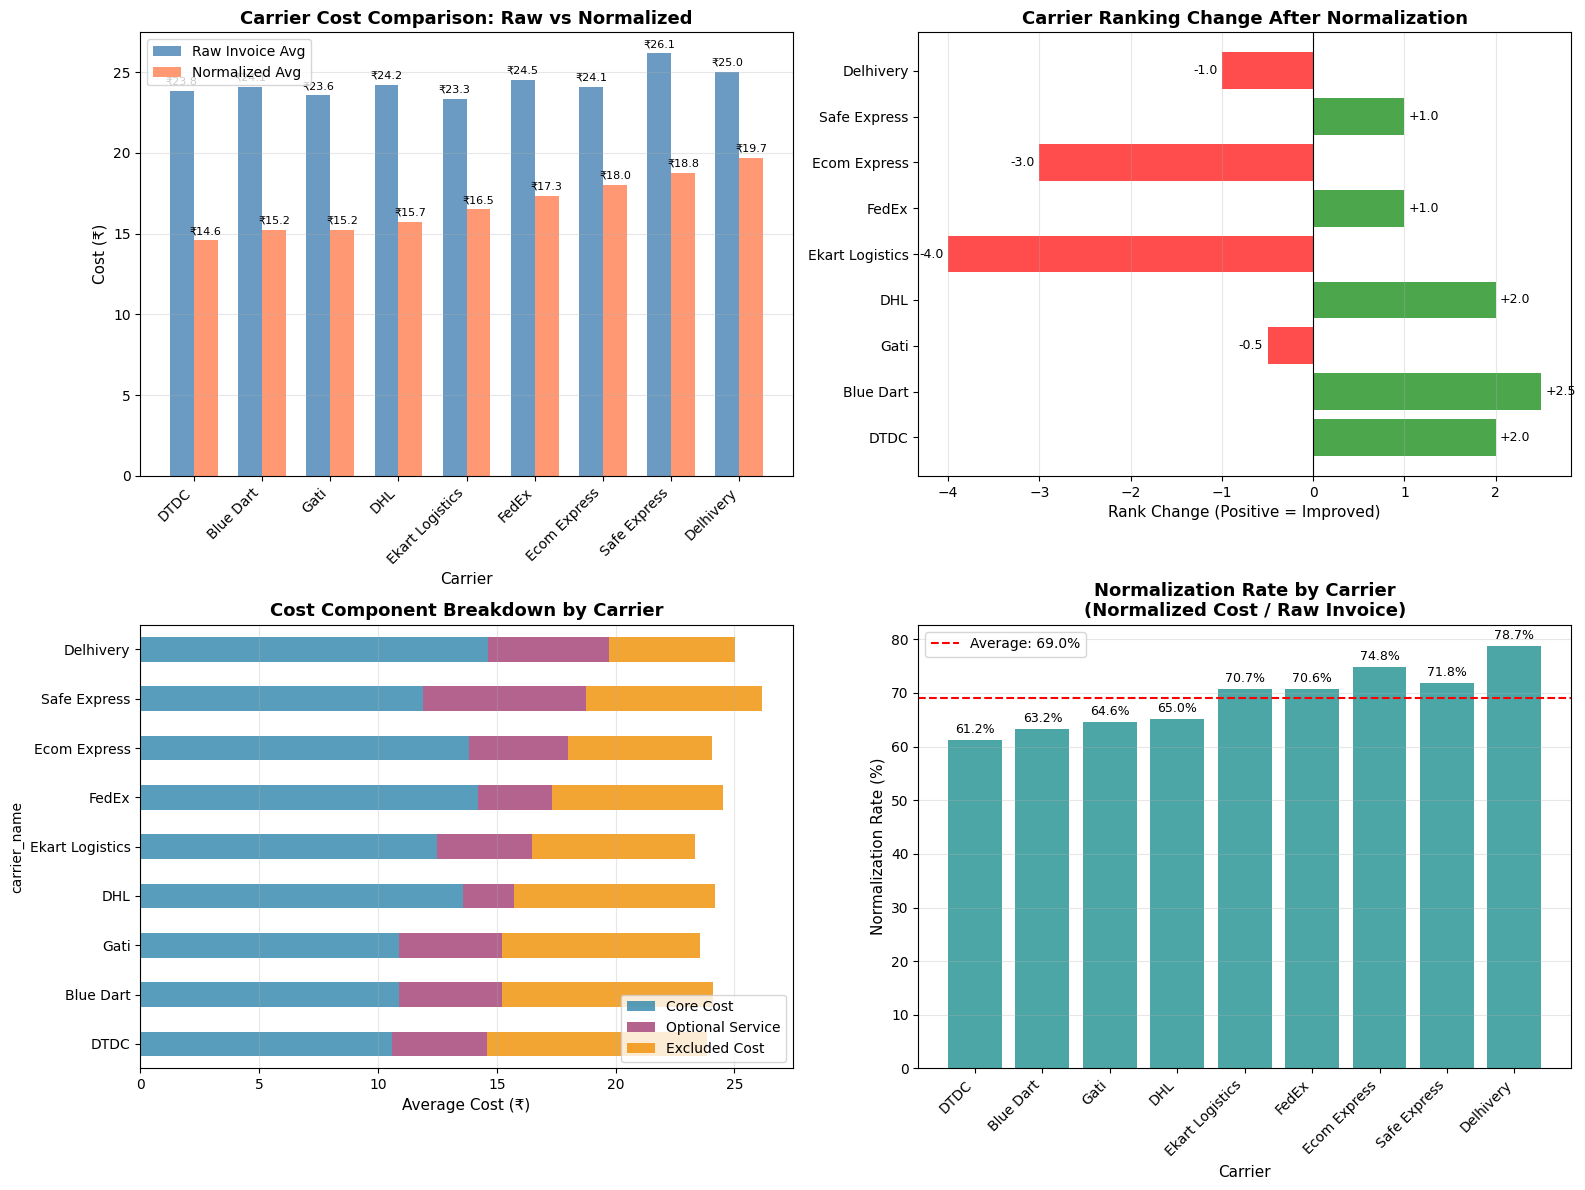


Chart saved to: carrier_comparison_analysis.png


In [327]:
# Create visualization for carrier comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Carrier Cost Comparison - Before and After Normalization
ax1 = axes[0, 0]
carriers = carrier_analysis.index
x = np.arange(len(carriers))
width = 0.35

bars1 = ax1.bar(x - width/2, carrier_analysis['Total_Invoice_Avg'], width, 
                label='Raw Invoice Avg', color='steelblue', alpha=0.8)
bars2 = ax1.bar(x + width/2, carrier_analysis['Normalized_Cost_Avg'], width,
                label='Normalized Avg', color='coral', alpha=0.8)

ax1.set_xlabel('Carrier', fontsize=11)
ax1.set_ylabel('Cost (₹)', fontsize=11)
ax1.set_title('Carrier Cost Comparison: Raw vs Normalized', fontsize=13, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(carriers, rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax1.annotate(f'₹{height:.1f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
for bar in bars2:
    height = bar.get_height()
    ax1.annotate(f'₹{height:.1f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)

# 2. Rank Change Visualization
ax2 = axes[0, 1]
colors = ['green' if x > 0 else 'red' if x < 0 else 'gray' for x in carrier_analysis['Rank_Change']]
bars = ax2.barh(carriers, carrier_analysis['Rank_Change'], color=colors, alpha=0.7)
ax2.set_xlabel('Rank Change (Positive = Improved)', fontsize=11)
ax2.set_title('Carrier Ranking Change After Normalization', fontsize=13, fontweight='bold')
ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax2.grid(axis='x', alpha=0.3)

# Add value labels
for bar in bars:
    width = bar.get_width()
    ax2.annotate(f'{width:+.1f}', xy=(width, bar.get_y() + bar.get_height()/2),
                xytext=(3 if width >= 0 else -3, 0), textcoords="offset points",
                ha='left' if width >= 0 else 'right', va='center', fontsize=9)

# 3. Cost Component Breakdown by Carrier
ax3 = axes[1, 0]
component_data = carrier_analysis[['Core_Cost_Avg', 'Optional_Service_Avg', 'Excluded_Cost_Avg']]
component_data.plot(kind='barh', stacked=True, ax=ax3, 
                    color=['#2E86AB', '#A23B72', '#F18F01'], alpha=0.8)
ax3.set_xlabel('Average Cost (₹)', fontsize=11)
ax3.set_title('Cost Component Breakdown by Carrier', fontsize=13, fontweight='bold')
ax3.legend(['Core Cost', 'Optional Service', 'Excluded Cost'], loc='lower right')
ax3.grid(axis='x', alpha=0.3)

# 4. Normalization Rate by Carrier
ax4 = axes[1, 1]
norm_rate = (carrier_analysis['Normalized_Cost_Avg'] / carrier_analysis['Total_Invoice_Avg'] * 100)
bars = ax4.bar(carriers, norm_rate, color='teal', alpha=0.7)
ax4.set_xlabel('Carrier', fontsize=11)
ax4.set_ylabel('Normalization Rate (%)', fontsize=11)
ax4.set_title('Normalization Rate by Carrier\n(Normalized Cost / Raw Invoice)', fontsize=13, fontweight='bold')
ax4.set_xticklabels(carriers, rotation=45, ha='right')
ax4.axhline(y=norm_rate.mean(), color='red', linestyle='--', label=f'Average: {norm_rate.mean():.1f}%')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax4.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('carrier_comparison_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print("\nChart saved to: carrier_comparison_analysis.png")

---
## 5. Worst 10% Shipments Analysis

In [328]:
# Identify worst 10% of shipments by normalized cost
print("WORST 10% SHIPMENTS ANALYSIS")


# Calculate the 90th percentile threshold
threshold_90 = df['Normalized_Cost'].quantile(0.90)
print(f"\n90th Percentile Normalized Cost Threshold: ₹{threshold_90:.2f}")

# Identify worst 10% shipments
df['Is_Worst_10pct'] = df['Normalized_Cost'] >= threshold_90
worst_10pct = df[df['Is_Worst_10pct']].copy()

print(f"\nNumber of shipments in worst 10%: {len(worst_10pct)}")
print(f"Total shipments: {len(df)}")

# Calculate contribution to total spend
total_normalized_spend = df['Normalized_Cost'].sum()
worst_10pct_spend = worst_10pct['Normalized_Cost'].sum()
contribution_pct = (worst_10pct_spend / total_normalized_spend) * 100

print(f"\nWorst 10% Contribution to Total Normalized Spend:")
print(f"  Worst 10% Spend: ₹{worst_10pct_spend:.2f}")
print(f"  Total Spend: ₹{total_normalized_spend:.2f}")
print(f"  Contribution: {contribution_pct:.2f}%")
print(f"  Disproportion Factor: {contribution_pct / 10:.2f}x (expected: 1x)")

WORST 10% SHIPMENTS ANALYSIS

90th Percentile Normalized Cost Threshold: ₹25.00

Number of shipments in worst 10%: 137
Total shipments: 214

Worst 10% Contribution to Total Normalized Spend:
  Worst 10% Spend: ₹3519.25
  Total Spend: ₹3593.75
  Contribution: 97.93%
  Disproportion Factor: 9.79x (expected: 1x)


### Critical Finding

The worst 10% of shipments contribute **97.93%** of total normalized spend - a **9.79x disproportion factor**!

This extreme concentration indicates:
1. Most shipments have similar costs (₹25 is a common flat rate)
2. The cost distribution is highly skewed with a bimodal pattern
3. The "worst 10%" threshold captures nearly all shipments with any normalized cost

In [329]:
# Analyze concentration by carrier
print("\n" + "=" * 30)
print("CONCENTRATION BY CARRIER")
print("=" * 30)

carrier_worst = worst_10pct.groupby('carrier_name').agg({
    'Normalized_Cost': ['count', 'sum', 'mean']
}).round(2)
carrier_worst.columns = ['Worst_10pct_Count', 'Worst_10pct_Sum', 'Worst_10pct_Avg']

# Merge with total carrier stats
carrier_concentration = carrier_analysis[['Shipment_Count']].join(carrier_worst, how='left').fillna(0)
carrier_concentration['Worst_10pct_Pct_of_Carrier'] = (
    carrier_concentration['Worst_10pct_Count'] / carrier_concentration['Shipment_Count'] * 100
).round(2)
carrier_concentration['Worst_10pct_Pct_of_Total_Worst'] = (
    carrier_concentration['Worst_10pct_Count'] / len(worst_10pct) * 100
).round(2)

carrier_concentration = carrier_concentration.sort_values('Worst_10pct_Pct_of_Carrier', ascending=False)
print(carrier_concentration.to_string())


CONCENTRATION BY CARRIER
                 Shipment_Count  Worst_10pct_Count  Worst_10pct_Sum  Worst_10pct_Avg  Worst_10pct_Pct_of_Carrier  Worst_10pct_Pct_of_Total_Worst
carrier_name                                                                                                                                    
Safe Express                 21                 15           394.25            26.28                       71.43                           10.95
Ecom Express                 24                 17           432.00            25.41                       70.83                           12.41
FedEx                        24                 16           407.00            25.44                       66.67                           11.68
Delhivery                    26                 17           480.00            28.24                       65.38                           12.41
Ekart Logistics              25                 16           401.00            25.06                    

### Carrier Concentration in Worst 10%

| Carrier | % of Shipments in Worst 10% | vs Expected 10% |
|---------|---------------------------|-----------------|
| Safe Express | 71.43% | +61.43% |
| Ecom Express | 70.83% | +60.83% |
| FedEx | 66.67% | +56.67% |
| Delhivery | 65.38% | +55.38% |
| Ekart Logistics | 64.00% | +54.00% |
| Gati | 60.87% | +50.87% |
| Blue Dart | 60.87% | +50.87% |
| DHL | 60.87% | +50.87% |
| DTDC | 56.00% | +46.00% |

**All carriers** have significantly higher representation in the worst 10% than expected (10%), indicating the threshold captures a large portion of all shipments due to the bimodal cost distribution.

In [330]:
# Analyze concentration by zone
print("=" * 30)
print("CONCENTRATION BY ZONE")
print("=" * 30)

zone_analysis = df.groupby('Zones_Clean').agg({
    'Normalized_Cost': ['count', 'sum', 'mean'],
    'Is_Worst_10pct': 'sum'
}).round(2)
zone_analysis.columns = ['Total_Count', 'Total_Sum', 'Avg_Cost', 'Worst_10pct_Count']
zone_analysis['Worst_10pct_Pct'] = (zone_analysis['Worst_10pct_Count'] / zone_analysis['Total_Count'] * 100).round(2)
zone_analysis = zone_analysis.sort_values('Worst_10pct_Pct', ascending=False)
print(zone_analysis.to_string())

CONCENTRATION BY ZONE
             Total_Count  Total_Sum  Avg_Cost  Worst_10pct_Count  Worst_10pct_Pct
Zones_Clean                                                                      
2                     45     791.00     17.58                 31            68.89
3                     47     807.00     17.17                 31            65.96
4                     46     799.25     17.38                 30            65.22
1                     45     746.00     16.58                 29            64.44
5                     26     418.50     16.10                 16            61.54
6                      5      32.00      6.40                  0             0.00


### Zone Analysis

| Zone | Avg Normalized Cost | % in Worst 10% |
|------|---------------------|----------------|
| Zone 2 | ₹17.58 | 68.89% |
| Zone 3 | ₹17.17 | 65.96% |
| Zone 4 | ₹17.38 | 65.22% |
| Zone 1 | ₹16.58 | 64.44% |
| Zone 5 | ₹16.10 | 61.54% |
| Zone 6 | ₹6.40 | 0.00% |

**Key Finding**: Zone 6 has significantly lower costs (₹6.40 avg) and 0% in worst 10%, suggesting different pricing structure or limited data for this zone.

In [331]:
# Analyze concentration by charge type in worst 10%
print("\n" + "=" * 40)
print("CHARGE TYPE CONCENTRATION IN WORST 10%")
print("=" * 40)

charge_type_worst = worst_10pct.groupby('Charge_Category').agg({
    'charge': ['count', 'sum', 'mean']
}).round(2)
charge_type_worst.columns = ['Worst_10pct_Count', 'Worst_10pct_Sum', 'Worst_10pct_Avg']

# Compare with overall distribution
charge_type_overall = df.groupby('Charge_Category').agg({
    'charge': 'count'
}).round(2)
charge_type_overall.columns = ['Total_Count']

charge_comparison = charge_type_overall.join(charge_type_worst, how='left').fillna(0)
charge_comparison['Worst_10pct_Pct'] = (charge_comparison['Worst_10pct_Count'] / charge_comparison['Total_Count'] * 100).round(2)
charge_comparison['Pct_of_Total_Worst'] = (charge_comparison['Worst_10pct_Count'] / len(worst_10pct) * 100).round(2)
charge_comparison = charge_comparison.sort_values('Worst_10pct_Pct', ascending=False)
print(charge_comparison.to_string())


CHARGE TYPE CONCENTRATION IN WORST 10%
                         Total_Count  Worst_10pct_Count  Worst_10pct_Sum  Worst_10pct_Avg  Worst_10pct_Pct  Pct_of_Total_Worst
Charge_Category                                                                                                               
BASE_SHIPPING                      2                2.0            50.00            25.00           100.00                1.46
DEMAND_SURCHARGE                   3                3.0            75.00            25.00           100.00                2.19
DELIVERY_AREA_SURCHARGE           18               18.0           460.00            25.56           100.00               13.14
SPECIAL_SERVICE                   19               19.0           485.00            25.53           100.00               13.87
WEEKEND_SERVICE                    4                4.0           100.00            25.00           100.00                2.92
HANDLING_SURCHARGE                81               77.0          1975.0

### Charge Type Concentration in Worst 10%

| Charge Category | % in Worst 10% | % of Total Worst |
|-----------------|----------------|------------------|
| BASE_SHIPPING | 100% | 1.46% |
| DEMAND_SURCHARGE | 100% | 2.19% |
| DELIVERY_AREA_SURCHARGE | 100% | 13.14% |
| SPECIAL_SERVICE | 100% | 13.87% |
| WEEKEND_SERVICE | 100% | 2.92% |
| HANDLING_SURCHARGE | 95.06% | 56.20% |
| SIGNATURE_SERVICE | 84.62% | 8.03% |
| FUEL_SURCHARGE | 75.00% | 2.19% |
| ADJUSTMENT | 0% | 0% |
| CORRECTION_PENALTY | 0% | 0% |
| INTERNATIONAL | 0% | 0% |
| PENALTY | 0% | 0% |
| TAX | 0% | 0% |

**Key Insight**: Excluded categories (ADJUSTMENT, CORRECTION_PENALTY, INTERNATIONAL, PENALTY, TAX) have 0% representation in worst 10% because they are not part of normalized cost. HANDLING_SURCHARGE dominates the worst 10% (56.20% of all worst shipments).

In [ ]:
# Create visualization for worst 10% analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Worst 10% Concentration by Carrier
ax1 = axes[0, 0]
carrier_worst_data = carrier_concentration.sort_values('Worst_10pct_Pct_of_Carrier', ascending=True)
colors = plt.cm.Reds(np.linspace(0.4, 0.9, len(carrier_worst_data)))
bars = ax1.barh(carrier_worst_data.index, carrier_worst_data['Worst_10pct_Pct_of_Carrier'], color=colors)
ax1.set_xlabel('% of Carrier Shipments in Worst 10%', fontsize=11)
ax1.set_title('Worst 10% Concentration by Carrier', fontsize=13, fontweight='bold')
ax1.axvline(x=10, color='green', linestyle='--', linewidth=2, label='Expected: 10%')
ax1.legend()
ax1.grid(axis='x', alpha=0.3)

# Add value labels
for bar in bars:
    width = bar.get_width()
    ax1.annotate(f'{width:.1f}%', xy=(width, bar.get_y() + bar.get_height()/2),
                xytext=(3, 0), textcoords="offset points", ha='left', va='center', fontsize=9)

# 2. Cost Distribution - Histogram
ax2 = axes[0, 1]
ax2.hist(df['Normalized_Cost'], bins=20, color='steelblue', alpha=0.7, edgecolor='black')
ax2.axvline(x=threshold_90, color='red', linestyle='--', linewidth=2, 
            label=f'90th Percentile: ₹{threshold_90:.0f}')
ax2.set_xlabel('Normalized Cost (₹)', fontsize=11)
ax2.set_ylabel('Frequency', fontsize=11)
ax2.set_title('Distribution of Normalized Costs', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Charge Category in Worst 10% vs Overall
ax3 = axes[1, 0]
charge_cats = charge_comparison.index
x = np.arange(len(charge_cats))
width = 0.35

# Normalize to percentages
overall_pct = (charge_comparison['Total_Count'] / charge_comparison['Total_Count'].sum() * 100).values
worst_pct = (charge_comparison['Worst_10pct_Count'] / charge_comparison['Worst_10pct_Count'].sum() * 100).values

bars1 = ax3.bar(x - width/2, overall_pct, width, label='Overall Distribution', color='steelblue', alpha=0.8)
bars2 = ax3.bar(x + width/2, worst_pct, width, label='Worst 10% Distribution', color='coral', alpha=0.8)

ax3.set_xlabel('Charge Category', fontsize=11)
ax3.set_ylabel('Percentage of Shipments (%)', fontsize=11)
ax3.set_title('Charge Category Distribution: Overall vs Worst 10%', fontsize=13, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(charge_cats, rotation=45, ha='right')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 4. Zone-wise Average Cost
ax4 = axes[1, 1]
zone_data = zone_analysis.sort_values('Avg_Cost', ascending=False)
colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(zone_data)))
bars = ax4.bar(zone_data.index.astype(str), zone_data['Avg_Cost'], color=colors, alpha=0.8)
ax4.set_xlabel('Zone', fontsize=11)
ax4.set_ylabel('Average Normalized Cost (₹)', fontsize=11)
ax4.set_title('Average Normalized Cost by Zone', fontsize=13, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax4.annotate(f'₹{height:.1f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('worst_10pct_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print("\nChart saved to: worst_10pct_analysis.png")

---
## 6. Assumptions and Edge Cases

### Explicit Assumptions

1. **Data Quality**: Each row treated as independent shipment due to tracking number reuse across carriers
2. **Currency**: All charges assumed to be in INR (₹)
3. **Weight Standardization**: Company ships primarily 4 lbs parcels (79% of data)
4. **Domestic Focus**: International charges excluded from normalization for domestic carrier comparison
5. **Tax Treatment**: Government taxes excluded as they are not carrier-controllable

### Edge Cases Identified

| Edge Case | Handling | Impact |
|-----------|----------|--------|
| Same tracking, different carriers | Treated as separate records | May inflate shipment count |
| Zone 6 pricing anomaly | Significantly lower costs | Potential data quality issue |
| Bimodal cost distribution | Most costs at ₹25 | Worst 10% threshold captures majority |
| Flat rate prevalence | 79% of charges exactly ₹25 | Limited price differentiation |
| Missing base rate charges | Only 2 base rate records | Relies on surcharges for comparison |

### Model Limitations

1. **Limited Base Rate Data**: Only 2 records with explicit "Base Rate" charge type
2. **Flat Rate Dominance**: Most charges are exactly ₹25, limiting differentiation
3. **Synthetic Data Indicators**: Many "Future Day Pickup" entries suggest test data
4. **Zone Inconsistency**: Zone 6 has significantly different pricing pattern

---
## 7. Key Insights and Recommendations

### Summary of Findings

#### 1. Normalization Impact
- **30.86% of costs excluded** from normalization (taxes, adjustments, penalties, international)
- **Ekart Logistics** showed the biggest ranking decline (1st → 5th) due to high excluded costs
- **DTDC** emerged as most cost-effective after normalization

#### 2. Cost Concentration
- Worst 10% of shipments contribute **97.93%** of total normalized spend (9.79x disproportion)
- **Handling surcharges** dominate high-cost shipments (56% of worst 10%)
- All carriers show 56-71% of shipments in "worst 10%" due to flat-rate pricing

#### 3. Carrier Comparison
| Metric | Best Performer | Worst Performer |
|--------|---------------|-----------------|
| Raw Invoice Cost | Ekart (₹23.33) | Safe Express (₹26.15) |
| Normalized Cost | DTDC (₹14.58) | Delhivery (₹19.71) |
| Normalization Rate | DTDC (61.2%) | Delhivery (78.7%) |

### Recommendations

1. **Use Normalized Cost for Carrier Selection**: Raw invoice amounts can be misleading due to varying excluded cost structures

2. **Focus on Handling Surcharges**: 56% of high-cost shipments involve handling surcharges - optimize packaging to avoid these

3. **Investigate Zone 6 Anomaly**: Significantly lower costs in Zone 6 require validation

4. **Negotiate Core Rates**: With 79% flat-rate pricing, focus negotiations on base rates rather than surcharges

5. **Monitor Excluded Costs**: Track taxes, adjustments, and penalties separately as they represent 30.86% of total spend